In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml-olympiad-for-students-topvistos-eua/sample_submission.csv
/kaggle/input/ml-olympiad-for-students-topvistos-eua/train.csv
/kaggle/input/ml-olympiad-for-students-topvistos-eua/test.csv


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeRegressor
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Leitura e Análise Exploratória dos Dados

In [4]:
# Carregando os dados
df = pd.read_csv('/kaggle/input/ml-olympiad-for-students-topvistos-eua/train.csv')
#df_test = pd.read_csv('/kaggle/input/ml-olympiad-for-students-topvistos-eua/test.csv')

In [5]:
# Verificando o tamanho dos dados
df.shape

(17836, 12)

In [6]:
# Verificando as primeiras linhas dos dados de treinamento
df.head()

,id_do_caso,continente,educacao_do_empregado,tem_experiencia_de_trabalho,requer_treinamento_de_trabalho,num_de_empregados,ano_de_estabelecimento,regiao_de_emprego,salario_prevalecente,unidade_de_salario,posicao_em_tempo_integral,status_do_caso
0,EZYV10567,Europa,Ensino Médio,N,S,2087,1855,Sul,69711.24,Ano,S,Negado
1,EZYV5505,Ásia,Mestrado,S,N,5991,2003,Meio-Oeste,52931.38,Ano,S,Aprovado
2,EZYV5207,Ásia,Ensino Médio,N,N,1426,2000,Ilha,110830.21,Ano,S,Negado
3,EZYV7545,Ásia,Ensino Médio,N,N,3846,1992,Meio-Oeste,91884.68,Semana,S,Negado
4,EZYV16071,Ásia,Ensino Superior,S,N,3957,1949,Nordeste,138155.24,Ano,S,Aprovado


In [7]:
# Verificando informações gerais dos dados de treinamento
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17836 entries, 0 to 17835
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id_do_caso                      17836 non-null  object 
 1   continente                      17836 non-null  object 
 2   educacao_do_empregado           17836 non-null  object 
 3   tem_experiencia_de_trabalho     17836 non-null  object 
 4   requer_treinamento_de_trabalho  17836 non-null  object 
 5   num_de_empregados               17836 non-null  int64  
 6   ano_de_estabelecimento          17836 non-null  int64  
 7   regiao_de_emprego               17836 non-null  object 
 8   salario_prevalecente            17836 non-null  float64
 9   unidade_de_salario              17836 non-null  object 
 10  posicao_em_tempo_integral       17836 non-null  object 
 11  status_do_caso                  17836 non-null  object 
dtypes: float64(1), int64(2), object(

In [8]:
# Verificando estatísticas descritivas dos dados quantitativos
df.describe()

,num_de_empregados,ano_de_estabelecimento,salario_prevalecente
count,17836.00000,17836.000000,17836.000000
mean,5726.50185,1979.494898,74327.428401
std,23321.37739,42.097194,52795.859573
min,-26.00000,1800.000000,2.136700
25%,1023.00000,1976.000000,33892.912500
50%,2117.00000,1997.000000,70106.920000
75%,3504.25000,2005.000000,107564.715000
max,602069.00000,2016.000000,319210.270000


In [9]:
# Verificando a contagem de valores únicos em cada coluna dos dados
df.nunique()

id_do_caso                        17836
continente                            6
educacao_do_empregado                 4
tem_experiencia_de_trabalho           2
requer_treinamento_de_trabalho        2
num_de_empregados                  6294
ano_de_estabelecimento              199
regiao_de_emprego                     5
salario_prevalecente              17827
unidade_de_salario                    4
posicao_em_tempo_integral             2
status_do_caso                        2
dtype: int64

In [10]:
# Verificando os valores nulos em cada coluna dos dados
df.isnull().sum()

id_do_caso                        0
continente                        0
educacao_do_empregado             0
tem_experiencia_de_trabalho       0
requer_treinamento_de_trabalho    0
num_de_empregados                 0
ano_de_estabelecimento            0
regiao_de_emprego                 0
salario_prevalecente              0
unidade_de_salario                0
posicao_em_tempo_integral         0
status_do_caso                    0
dtype: int64

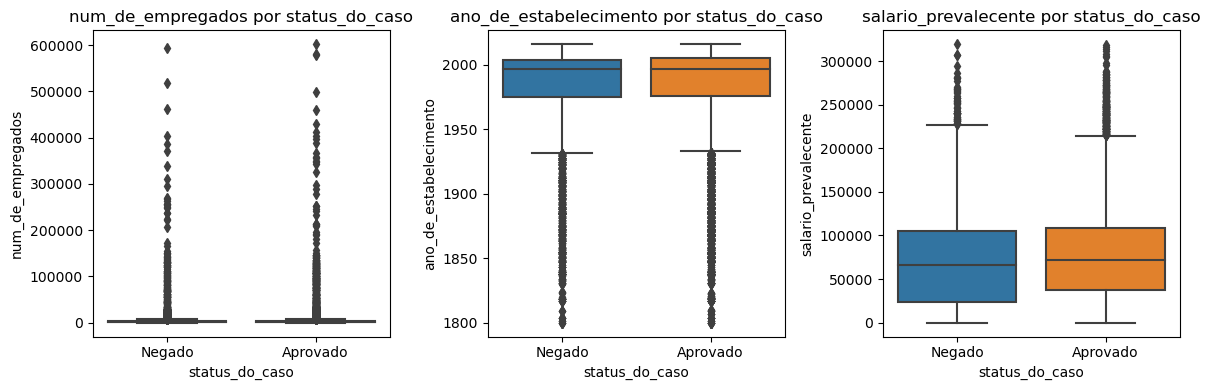

In [11]:
# Analisando as variáveis quantitativas
quantitative_vars = ['num_de_empregados', 'ano_de_estabelecimento', 'salario_prevalecente']
status_counts = df['status_do_caso'].value_counts()

fig, axes = plt.subplots(nrows=1, ncols=len(quantitative_vars), figsize=(12, 4))

for i, var in enumerate(quantitative_vars):
    sns.boxplot(x='status_do_caso', y=var, data=df, ax=axes[i])
    axes[i].set_title(f'{var} por status_do_caso')

plt.tight_layout()
plt.show()

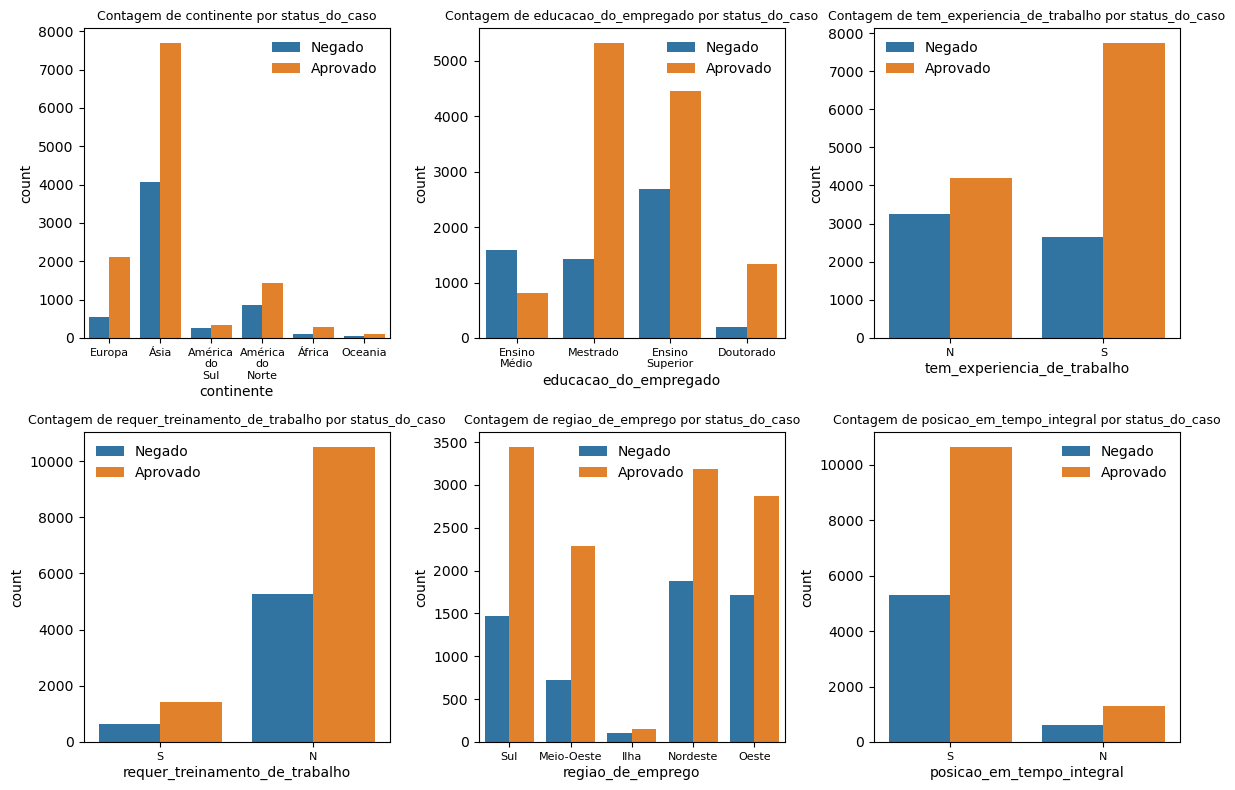

In [12]:
# Analisando as variáveis qualitativas
qualitative_vars = ['continente', 'educacao_do_empregado', 'tem_experiencia_de_trabalho',
                    'requer_treinamento_de_trabalho', 'regiao_de_emprego', 'posicao_em_tempo_integral']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

for i, var in enumerate(qualitative_vars):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    sns.countplot(x=var, hue='status_do_caso', data=df, ax=ax)
    ax.set_title(f'Contagem de {var} por status_do_caso', fontsize=9)
    ax.tick_params(axis='x', labelsize=8)
    
    # Quebra de linha nas palavras compostas e ajusta o nome do eixo X
    xticklabels = [label.get_text().replace(' ', '\n') for label in ax.get_xticklabels()]
    ax.set_xticklabels(xticklabels)
    ax.set_xlabel(var, fontsize=10, labelpad=3)  # Define o tamanho e a posição do nome do eixo X
    
    # Configurações da legenda
    legend = ax.legend()
    legend.get_frame().set_alpha(0.0) # Torna o fundo da legenda transparente
    for text in legend.get_texts():
        text.set_fontsize(10)  # Define o tamanho da fonte da legenda


plt.tight_layout()
plt.show()

# Pré-processamento dos dados

In [13]:
# Criando um dicionário de mapeamento
m = {'S': 1, 'N': 0, 'Aprovado': 1, 'Negado': 0}

# Aplicando o mapeamento nas colunas desejadas
df['tem_experiencia_de_trabalho'] = df['tem_experiencia_de_trabalho'].map(m)
df['requer_treinamento_de_trabalho'] = df['requer_treinamento_de_trabalho'].map(m)
df['posicao_em_tempo_integral'] = df['posicao_em_tempo_integral'].map(m)
df['status_do_caso'] = df['status_do_caso'].map(m)

In [14]:
# Removendo a coluna 'id_do_caso'
id_do_caso = df['id_do_caso']
df.drop('id_do_caso', axis=1, inplace=True)

In [16]:
# Verificando os dados do tipo objeto
for col in df.select_dtypes(include=['object']).columns:
    print(f"{col}:{df[col].unique()}")

continente:['Europa' 'Ásia' 'América do Sul' 'América do Norte' 'África' 'Oceania']
educacao_do_empregado:['Ensino Médio' 'Mestrado' 'Ensino Superior' 'Doutorado']
regiao_de_emprego:['Sul' 'Meio-Oeste' 'Ilha' 'Nordeste' 'Oeste']
unidade_de_salario:['Ano' 'Semana' 'Hora' 'Mês']


In [17]:
# Codificação de rótulo os dados do tipo objeto
for col in df.select_dtypes(include=['object']).columns:
        label_encoder=preprocessing.LabelEncoder()
        label_encoder.fit(df[col].unique())
        df[col]=label_encoder.transform(df[col])
        print (f"{col}:{df[col].unique()}")

continente:[2 5 1 0 4 3]
educacao_do_empregado:[1 3 2 0]
regiao_de_emprego:[4 1 0 2 3]
unidade_de_salario:[0 3 1 2]


<Axes: >

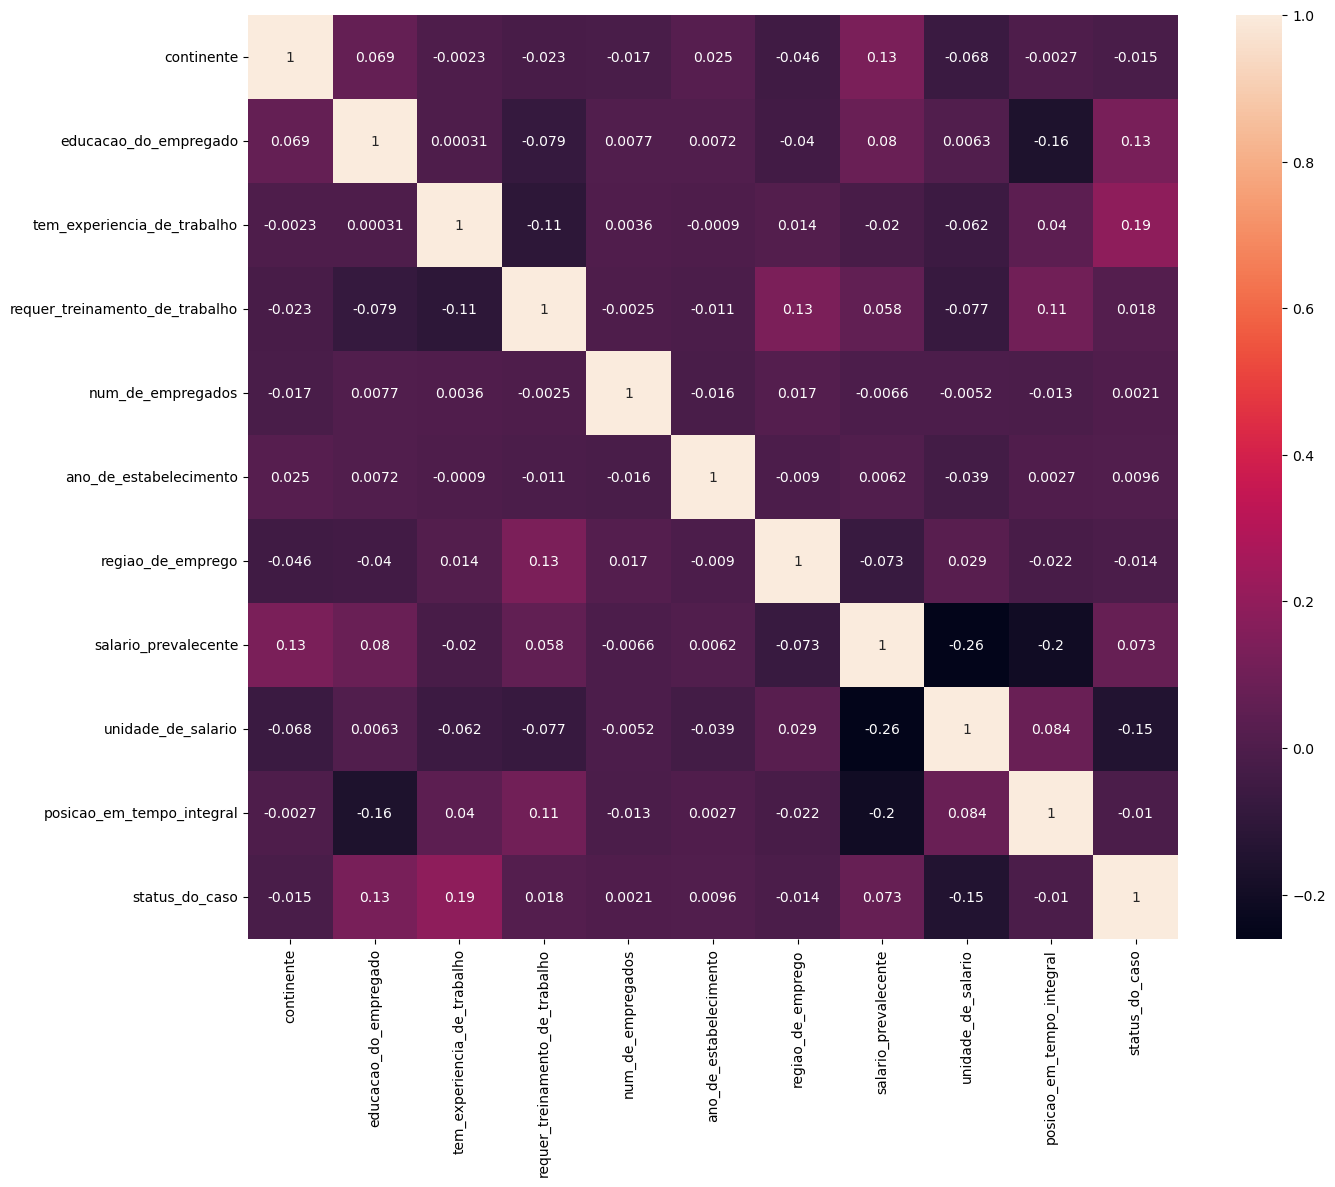

In [18]:
# Matriz de Correlação
plt.figure(figsize=(15,12))
sns.heatmap(df.corr(), fmt='.2g', annot=True)

# Train Test Split

In [19]:
# Declarando as variáveis
X = df.drop('status_do_caso', axis=1)
y = df['status_do_caso']

# Tamanho das amostras: Train 70%, Test 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Escolha do modelo

In [20]:
# Criando uma função para definir os modelos a serem testados e verificar as métricas de desempenho dos modelos

def model_test(x,y):
    gauss = GaussianNB()
    knn = KNeighborsClassifier()
    svm = SVC()
    bernoulli = BernoulliNB()
    rforest= RandomForestClassifier()
    gradboost = GradientBoostingClassifier()
    lreg = LogisticRegression()
    dtree = DecisionTreeClassifier()
    xgb = XGBClassifier()
    lgbm = LGBMClassifier()

    models = [gauss,knn,svm,bernoulli,rforest,gradboost,lreg,dtree,xgb,lgbm]
    model_names = ["GaussianNB","KNeighborsClassifier","SVC","BernoulliNB","RandomForestClassifier","GradientBoostingClassifier","LogisticRegression","DecisionTreeClassifier","XGBoost","LightGBM"]
    
    f1 = []
    acc = []
    prec = []
    rec = []
    #rocauc = []
 
    score = pd.DataFrame(columns = ["F1_Score","Accuracy_Score","Precision_Score","Recall_Score"],index = model_names)
    
    for model in models:
        model.fit(X_train,y_train)
        f1.append(f1_score(model.predict(X_test), y_test))
        acc.append(accuracy_score(model.predict(X_test),y_test))
        prec.append(precision_score(model.predict(X_test),y_test))
        rec.append(recall_score(model.predict(X_test),y_test))
        #rocauc.append(roc_auc_score(model.predict(X_test),y_test))

    score.F1_Score = f1        
    score.Accuracy_Score = acc
    score.Precision_Score = prec
    score.Recall_Score = rec
    #score.ROC_AUC = rocauc
    
    return score.sort_values("F1_Score", ascending=False)

In [21]:
# Testando os modelos
model_test(X,y)

,F1_Score,Accuracy_Score,Precision_Score,Recall_Score
GradientBoostingClassifier,0.821058,0.745281,0.865725,0.780774
LightGBM,0.818552,0.741917,0.862403,0.778945
XGBoost,0.807305,0.727901,0.844408,0.773327
SVC,0.805983,0.675201,0.999446,0.675271
LogisticRegression,0.805980,0.675014,1.000000,0.675014
GaussianNB,0.805055,0.674266,0.996401,0.675361
BernoulliNB,0.803975,0.690338,0.940753,0.701921
RandomForestClassifier,0.802560,0.723229,0.833333,0.773978
KNeighborsClassifier,0.745380,0.629228,0.803987,0.694737
DecisionTreeClassifier,0.733680,0.645487,0.723422,0.744232


Como o modelo GradientBoostingClassifier obteve o maior F1_Score, ele foi o modelo escolhido.

# Treinamento do Modelo

In [22]:
# Criando e treinando o modelo escolhido
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
gb_preds = gb.predict(X_test)

# Avaliando métricas de desempenho para o modelo escolhido
gb_accuracy = accuracy_score(y_test, gb_preds)
gb_precision = precision_score(y_test, gb_preds)
gb_recall = recall_score(y_test, gb_preds)
gb_f1 = f1_score(y_test, gb_preds)
gb_roc_auc = roc_auc_score(y_test, gb_preds)
gb_cfmatrix = confusion_matrix(y_test, gb_preds)

print("Gradient Boosting:")
print(f'Acurácia: {gb_accuracy}')
print(f'Precisão: {gb_precision}')
print(f'Recall: {gb_recall}')
print(f'F1-Score: {gb_f1}')
print(f'Área sob a curva ROC: {gb_roc_auc}')
print(f'Matriz de confusão: \n {gb_cfmatrix}')

Gradient Boosting:
Acurácia: 0.7452812558400299
Precisão: 0.7807740324594257
Recall: 0.8657253599114064
F1-Score: 0.8210581593803333
Área sob a curva ROC: 0.6804187466607061
Matriz de confusão: 
 [[ 861  878]
 [ 485 3127]]


# Ajustando o modelo

In [23]:
# Testando valores para o parâmetro 'learning_rates'
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(learning_rate = learning_rate, max_features=2, random_state = 42)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.4f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.4f}".format(gb.score(X_test, y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.7245
Accuracy score (validation): 0.7202

Learning rate:  0.1
Accuracy score (training): 0.7492
Accuracy score (validation): 0.7374

Learning rate:  0.25
Accuracy score (training): 0.7608
Accuracy score (validation): 0.7414

Learning rate:  0.5
Accuracy score (training): 0.7704
Accuracy score (validation): 0.7369

Learning rate:  0.75
Accuracy score (training): 0.7791
Accuracy score (validation): 0.7329

Learning rate:  1
Accuracy score (training): 0.7804
Accuracy score (validation): 0.7307



In [24]:
# Testando valores para o parâmetro 'n_estimators'
ns = [100, 200, 300, 600, 700, 800]
for n in ns:
    gb = GradientBoostingClassifier(n_estimators=n, max_features=2,random_state = 42)
    gb.fit(X_train, y_train)
    print("N_estimators ", n)
    print("Accuracy score (training): {0:.4f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.4f}".format(gb.score(X_test, y_test)))
    print()

N_estimators  100
Accuracy score (training): 0.7492
Accuracy score (validation): 0.7374

N_estimators  200
Accuracy score (training): 0.7583
Accuracy score (validation): 0.7436

N_estimators  300
Accuracy score (training): 0.7647
Accuracy score (validation): 0.7438

N_estimators  600
Accuracy score (training): 0.7773
Accuracy score (validation): 0.7449

N_estimators  700
Accuracy score (training): 0.7796
Accuracy score (validation): 0.7432

N_estimators  800
Accuracy score (training): 0.7836
Accuracy score (validation): 0.7402



In [25]:
# Testando valores para o parâmetro 'max_depth'
maxds = [1, 2, 3, 5, 7, 9]
for d in maxds:
    gb = GradientBoostingClassifier(max_depth=d, max_features=2,random_state = 42)
    gb.fit(X_train, y_train)
    print("N_estimators ", d)
    print("Accuracy score (training): {0:.4f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.4f}".format(gb.score(X_test, y_test)))
    print()

N_estimators  1
Accuracy score (training): 0.7056
Accuracy score (validation): 0.7058

N_estimators  2
Accuracy score (training): 0.7278
Accuracy score (validation): 0.7266

N_estimators  3
Accuracy score (training): 0.7492
Accuracy score (validation): 0.7374

N_estimators  5
Accuracy score (training): 0.7744
Accuracy score (validation): 0.7447

N_estimators  7
Accuracy score (training): 0.8226
Accuracy score (validation): 0.7384

N_estimators  9
Accuracy score (training): 0.8980
Accuracy score (validation): 0.7329



In [26]:
# Definindo os hiperparâmetros para busca em grade
param_grid = {
    'learning_rate': [0.05, 0.1, 0.25, 0.5, 0.75, 1],
    'n_estimators': [100, 200, 300, 600, 700, 800],
    'max_depth': [1, 2, 3, 5, 7, 9]
}

# Criando o modelo base
model = GradientBoostingClassifier(random_state=42)

# Realizando busca em grade com validação cruzada
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Obtendo os melhores hiperparâmetros encontrados
best_params = grid_search.best_params_
print("Melhores hiperparâmetros:", best_params)

# Avaliando o desempenho do modelo com os melhores hiperparâmetros
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

Melhores hiperparâmetros: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.65      0.49      0.56      1739
           1       0.78      0.87      0.82      3612

    accuracy                           0.75      5351
   macro avg       0.71      0.68      0.69      5351
weighted avg       0.74      0.75      0.74      5351



In [27]:
# Ajustando o modelo com os melhores hiperparâmetros
gbadj = GradientBoostingClassifier(learning_rate=0.05,max_depth=5,n_estimators=100,random_state=42)
gbadj.fit(X_train, y_train)
gbadj_preds = gbadj.predict(X_test)


# Predição

In [61]:
# Lendo os arquivos da base de teste
df_test.head()

,id_do_caso,continente,educacao_do_empregado,tem_experiencia_de_trabalho,requer_treinamento_de_trabalho,num_de_empregados,ano_de_estabelecimento,regiao_de_emprego,salario_prevalecente,unidade_de_salario,posicao_em_tempo_integral
0,EZYV22339,Ásia,Ensino Superior,S,N,2414,1973,Nordeste,103320.80,Ano,N
1,EZYV9333,Ásia,Mestrado,N,S,2928,1937,Oeste,49786.35,Ano,S
2,EZYV9740,Ásia,Ensino Superior,S,N,1836,1999,Oeste,60855.83,Ano,S
3,EZYV3328,Ásia,Ensino Superior,S,N,122,2004,Sul,82379.06,Semana,S
4,EZYV12321,América do Sul,Ensino Superior,S,S,1720,2003,Nordeste,6719.81,Ano,S


In [63]:
# Armazenando a coluna 'id_do_caso' da base de teste
df_test_id=df_test['id_do_caso']
df_test_id


0       EZYV22339
1        EZYV9333
2        EZYV9740
3        EZYV3328
4       EZYV12321
          ...    
7639    EZYV19907
7640      EZYV576
7641     EZYV1804
7642    EZYV13543
7643    EZYV17903
Name: id_do_caso, Length: 7644, dtype: object

In [66]:
# Criando um dataframe para preservar os dados de teste
df_test1=df_test.drop(['id_do_caso'],axis=1)
df_test1

,continente,educacao_do_empregado,tem_experiencia_de_trabalho,requer_treinamento_de_trabalho,num_de_empregados,ano_de_estabelecimento,regiao_de_emprego,salario_prevalecente,unidade_de_salario,posicao_em_tempo_integral
0,Ásia,Ensino Superior,S,N,2414,1973,Nordeste,103320.800,Ano,N
1,Ásia,Mestrado,N,S,2928,1937,Oeste,49786.350,Ano,S
2,Ásia,Ensino Superior,S,N,1836,1999,Oeste,60855.830,Ano,S
3,Ásia,Ensino Superior,S,N,122,2004,Sul,82379.060,Semana,S
4,América do Sul,Ensino Superior,S,S,1720,2003,Nordeste,6719.810,Ano,S
...,...,...,...,...,...,...,...,...,...,...
7639,América do Norte,Ensino Superior,N,N,66,2008,Oeste,70.599,Hora,S
7640,Ásia,Ensino Médio,S,N,4040,1994,Meio-Oeste,60158.590,Ano,S
7641,Ásia,Mestrado,S,N,32503,1925,Sul,44555.120,Ano,S
7642,América do Norte,Mestrado,S,N,1894,2000,Sul,97830.730,Ano,S


Fazendo o mesmo pré-processamento para os dados de teste

In [67]:
# Criando um dicionário de mapeamento
m = {'S': 1, 'N': 0, 'Aprovado': 1, 'Negado': 0}

# Aplicando o mapeamento nas colunas desejadas
df_test1['tem_experiencia_de_trabalho'] = df_test1['tem_experiencia_de_trabalho'].map(m)
df_test1['requer_treinamento_de_trabalho'] = df_test1['requer_treinamento_de_trabalho'].map(m)
df_test1['posicao_em_tempo_integral'] = df_test1['posicao_em_tempo_integral'].map(m)

df_test1

,continente,educacao_do_empregado,tem_experiencia_de_trabalho,requer_treinamento_de_trabalho,num_de_empregados,ano_de_estabelecimento,regiao_de_emprego,salario_prevalecente,unidade_de_salario,posicao_em_tempo_integral
0,Ásia,Ensino Superior,1,0,2414,1973,Nordeste,103320.800,Ano,0
1,Ásia,Mestrado,0,1,2928,1937,Oeste,49786.350,Ano,1
2,Ásia,Ensino Superior,1,0,1836,1999,Oeste,60855.830,Ano,1
3,Ásia,Ensino Superior,1,0,122,2004,Sul,82379.060,Semana,1
4,América do Sul,Ensino Superior,1,1,1720,2003,Nordeste,6719.810,Ano,1
...,...,...,...,...,...,...,...,...,...,...
7639,América do Norte,Ensino Superior,0,0,66,2008,Oeste,70.599,Hora,1
7640,Ásia,Ensino Médio,1,0,4040,1994,Meio-Oeste,60158.590,Ano,1
7641,Ásia,Mestrado,1,0,32503,1925,Sul,44555.120,Ano,1
7642,América do Norte,Mestrado,1,0,1894,2000,Sul,97830.730,Ano,1


In [69]:
# Codificação de rótulo os dados de teste do tipo objeto
for col in df_test1.select_dtypes(include=['object']).columns:
        label_encoder=preprocessing.LabelEncoder()
        label_encoder.fit(df_test1[col].unique())
        df_test1[col]=label_encoder.transform(df_test1[col])
        print (f"{col}:{df_test1[col].unique()}")

continente:[5 1 0 2 4 3]
educacao_do_empregado:[2 3 0 1]
regiao_de_emprego:[2 3 4 0 1]
unidade_de_salario:[0 3 1 2]


In [73]:
# Predição para a base de dados teste
preds = gbadj.predict(df_test1)
df_preds = pd.DataFrame()
df_preds["id_do_caso"] =df_test_id
df_preds["status_do_caso"] = preds
df_preds["status_do_caso"] = df_preds["status_do_caso"].astype('int32')
df_preds

,id_do_caso,status_do_caso
0,EZYV22339,1
1,EZYV9333,1
2,EZYV9740,1
3,EZYV3328,1
4,EZYV12321,1
...,...,...
7639,EZYV19907,0
7640,EZYV576,0
7641,EZYV1804,1
7642,EZYV13543,1


In [74]:
# Exportando o resultado da predição
df_preds.to_csv("submission.csv",index=False)
